# VLE with polymers

This is an example for a VLE calculation featuring a polymer and a solvent. PC-SAFT calculation for a water sorption isotherm of the polymer PVP were performed (the dotted line in Figure 2 of https://doi.org/10.3390/membranes12040434). 

In [1]:
import numpy as np
from epcsaftpy import component, pcsaft
from sgtpy.equilibrium import bubblePy   # sgtpy module
import matplotlib.pyplot as plt

Then let us define our components. Please note the warning about the failed critical point calculation for PVP. This is because its vapor pressure cannot be evaluated. 

In [3]:
Water = component('Water', ms = 1.2046817736, sigma = [2.7927, 10.11, -0.01775, -1.417, -0.01146], eps = 353.9449,
                 kappaAB = 0.045090, eAB = 2425.6714, sites = [0, 1, 1], Mw = 18.01528)
PVP = component('PVP', ms = 1045.99, sigma = 2.71 , eps = 205.599, 
               kappaAB = 0.02, eAB = 0., sites = [0, 231, 231], Mw = 25700.)
mix = Water + PVP
mix.set_kijsaft(i = 0, j = 1, kij0 = -0.128)
saft = pcsaft(mix, compute_critical = False)
saft_Water = saft.pure_eos[0]

Due to its non-existant vapor pressure, the polymer becomes a trace component in the vapor phase. Thus, the vapor phase consist of pure water.

In [4]:
T = 298.15
p0w, _, _ = saft_Water.psat(T)
yi = np.asarray([1, 0])

Due to the high molar mass of the polymer, mole fractions are very badly scaled. We supply a reasonable liquid-phase composition on a mass fraction basis and convert it to the mole fraction basis. 

In [5]:
wi = np.asarray([0.2, 0.8])
Mw = saft.Mw
xi_fun = lambda wi, Mw : wi / Mw / (wi / Mw).sum()
xi = xi_fun(wi, Mw)
pi = p0w * 0.5
res = bubblePy(yi, pi, xi, T, saft, full_output=True)
print(res)

      T: 298.15
      P: 2202.5333505750814
  error: 1.704910213007338e-09
   iter: 5
      X: array([0.99720391, 0.00279609])
     v1: 5.9013656218825026e-05
  Xassl: array([0.07485021, 0.07485021, 0.89266774, 0.89266774])
 state1: 'Liquid'
      Y: array([1., 0.])
     v2: 1.1233262594776208
  Xassv: array([0.9982009 , 0.9982009 , 0.99998074, 0.99998074])
 state2: 'Vapor'


And proceed the VLE calulcations for more points

In [6]:
n = 100
w1vec = np.linspace(1e-4, 1, n)
wvec = np.stack((w1vec, 1 - w1vec))
v0 = [None, None]
Xass0 = [None, None]
pivec = []
for i in range(n):
    wi = wvec[:,i]
    xi = xi_fun(wi, Mw)
    res = bubblePy(yi, pi, xi, T, saft, v0 = v0, Xass0 = Xass0, full_output = True)
    pi = res.P
    v0 = [res.v1, res.v2]
    Xass0 = [res.Xassl, res.Xassv]
    pivec.append(pi)
pivec = np.asarray(pivec)
RHvec = pivec / p0w

Next, we plot our results against the experimental data from https://doi.org/10.1016/j.jct.2004.04.008 as provided by Figure 2 in https://doi.org/10.3390/membranes12040434).

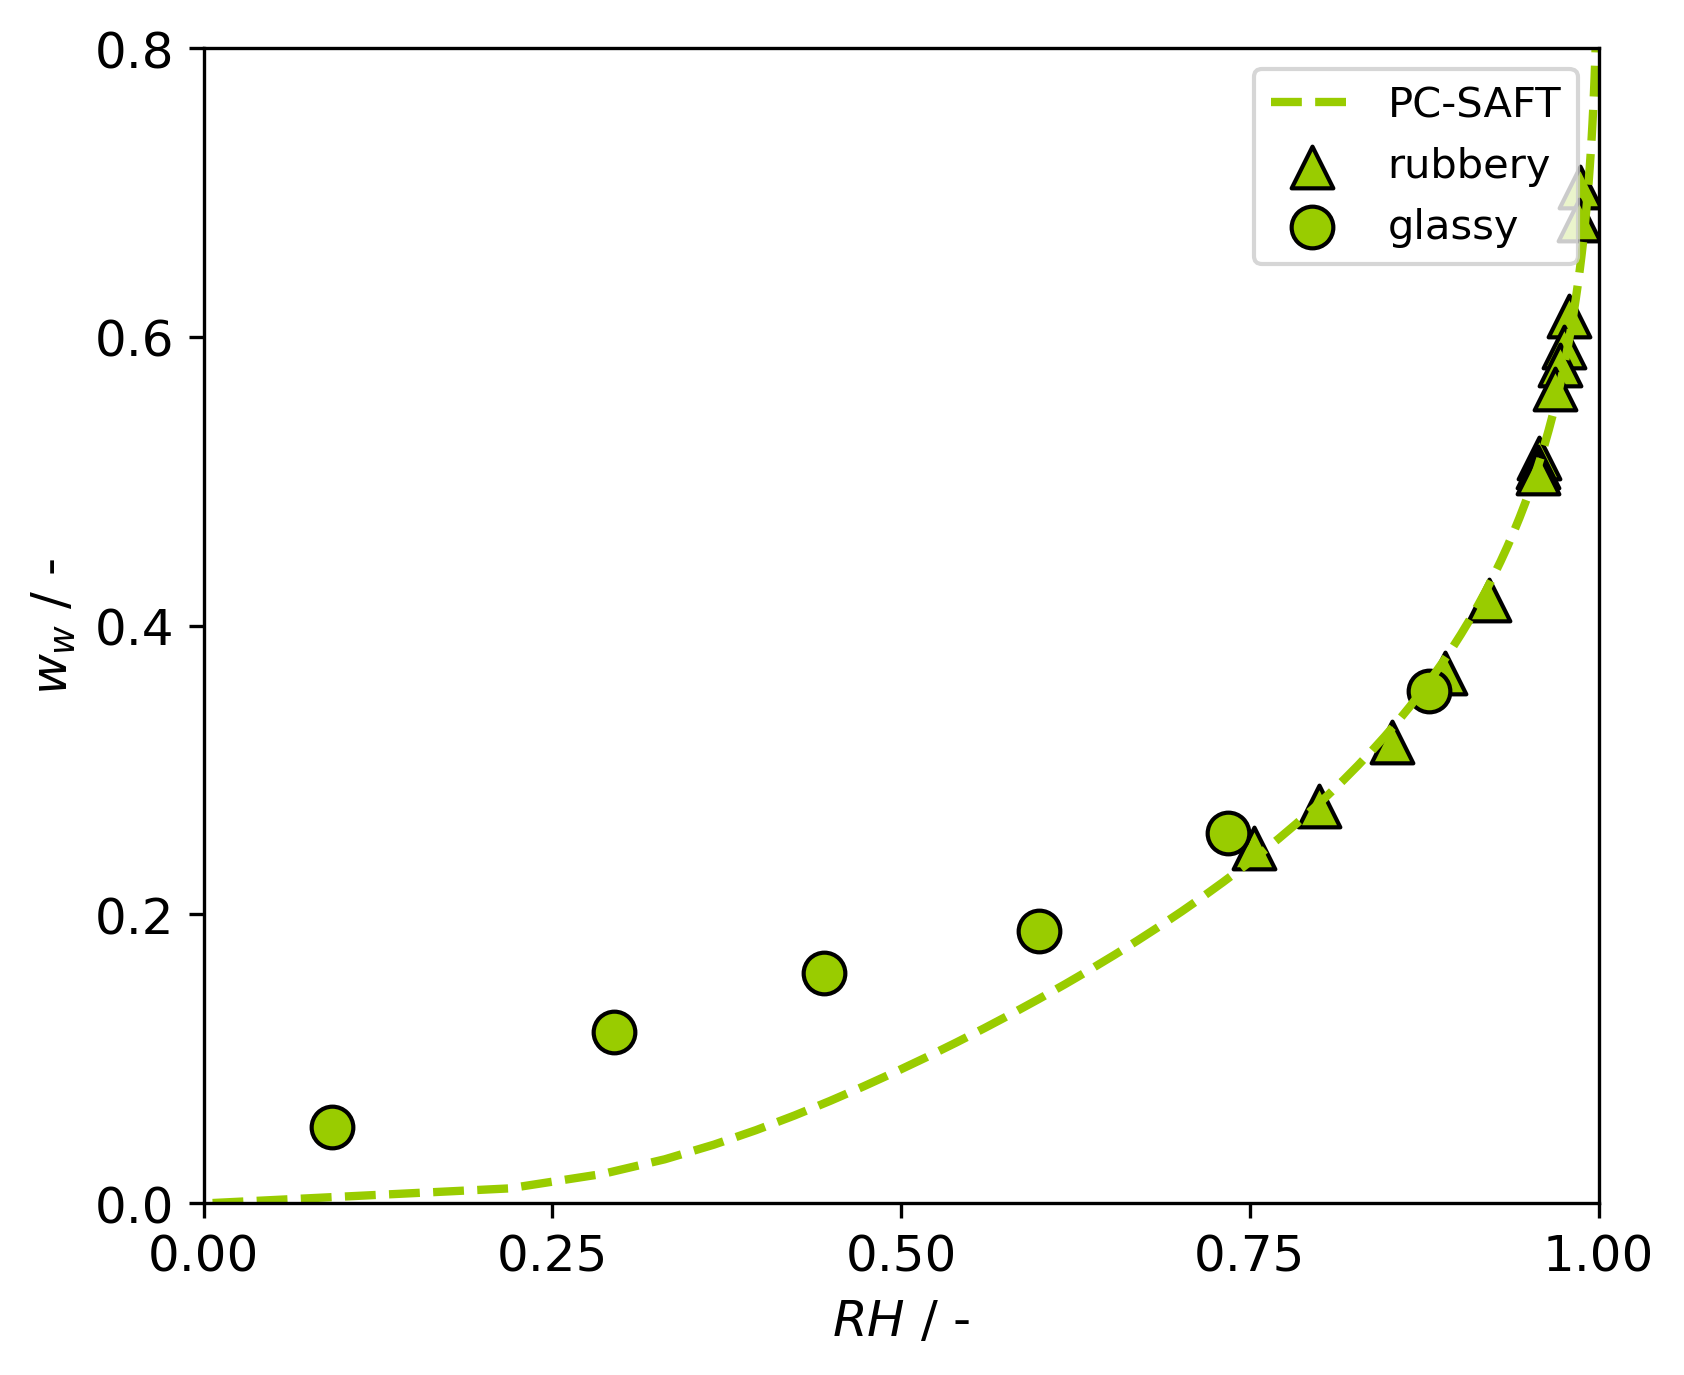

In [7]:
font = {'weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)

colorVLE = "#99CC00"

fig, ax = plt.subplots(figsize=(6, 5), dpi = 300)
fig.subplots_adjust(hspace=0.5, wspace=0.3)

RHexp=[0.9868,0.9858,0.9787,0.9749,0.9724,0.9685,0.9576,0.9565,0.9563,0.9217,0.89,0.8519,0.7998,0.7529]
wexp=[0.704,0.6808,0.6142,0.593,0.5808,0.5638,0.5162,0.5096,0.506,0.4175,0.3672,0.3193,0.275,0.246]

RHexp2=[0.0924,0.2939,0.4449,0.599,0.7344,0.8781]
wexp2=[0.05282,0.11878,0.15931,0.18878,0.25662,0.35504]


ax.plot(RHvec,wvec[0,:], "--",color = colorVLE , 
        linewidth = 2.0, label = "PC-SAFT")

ax.scatter(RHexp, wexp, s = 100, c = colorVLE, marker="^", 
            linewidth=1.0, edgecolor='k', label = "rubbery")
ax.scatter(RHexp2, wexp2, s = 100, c = colorVLE, marker="o", 
            linewidth=1.0, edgecolor='k', label = "glassy")



ax.legend(fontsize="small")
ax.set_ylabel('$w_w$ / -')
ax.set_xlabel('$RH$ / -')
ax.axis([0, 1., 0, 0.8])
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.linspace(start, end, 5))
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.linspace(start, end, 5))
plt.show()

As you may observe, the circles are not well represented by PC-SAFT. This is because these polymer-water mixtures were glassy which is a non-equilibrium state. Non-equilibrium states cannot be considered by PC-SAFT alone. Part 2 will consider the description of these datapoint using the so-called NET-GP approach(https://doi.org/10.1016/S0009-2509(98)00143-2)